<a href="https://colab.research.google.com/github/danlingzhou16/stat390/blob/GraceZhu/ARIMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

In [ ]:
def MAPE(y_true, y_pred):
  y_true, y_pred = np.array(y_true), np.array(y_pred)
  return np.mean(np.abs((y_true-y_pred)/y_true)) * 100

In [ ]:
def model_performance(y_true, y_pred):
  rmse = np.sqrt(mean_squared_error(y_true, y_pred))
  mape = MAPE(y_true, y_pred)
  return f"RMSE: {rmse}, MAPE: {mape}"

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
train = pd.read_csv('/content/gdrive/MyDrive/complete covid dataset/train_final.csv', index_col=['date'], parse_dates = ['date'])
test = pd.read_csv('/content/gdrive/MyDrive/complete covid dataset/test_final.csv', index_col=['date'], parse_dates = ['date'])

In [ ]:
train = train[~(train.index < '2020-03-01')]
test = test[~(test.index < '2020-03-01')]

In [ ]:
train = train[['country_code', 'new_confirmed']]
test = test[['country_code', 'new_confirmed']]

In [ ]:
# Method: Train model based on US dataset, then apply the model to the rest countries

In [ ]:
# group by countries
train_country = train.groupby(['country_code','date'])
test_country = test.groupby(['country_code','date'])
train_country_agg = train_country.agg('sum')
train_country_agg.reset_index(level = 'country_code', inplace = True)
test_country_agg = test_country.agg('sum')
test_country_agg.reset_index(level = 'country_code', inplace = True)

In [ ]:
train_country_agg.head()

,country_code,new_confirmed
date,,
2020-03-01,AU,0.0
2020-03-02,AU,0.0
2020-03-03,AU,0.0
2020-03-04,AU,3.0
2020-03-05,AU,3.0


In [ ]:
train_us = train_country_agg.loc[train_country_agg.country_code == 'US','new_confirmed']
test_us = test_country_agg.loc[test_country_agg.country_code == 'US','new_confirmed']

<Axes: xlabel='date'>

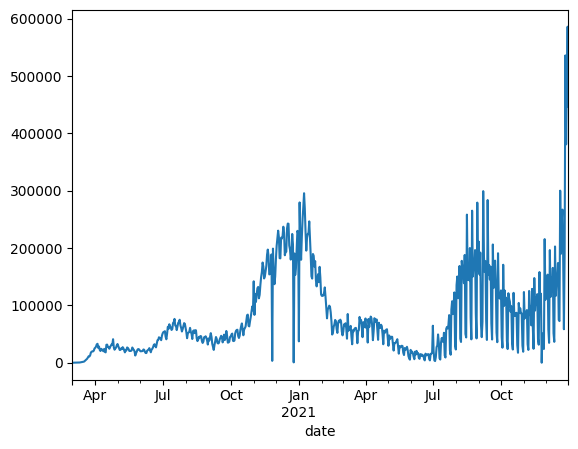

In [ ]:
train_us.plot()

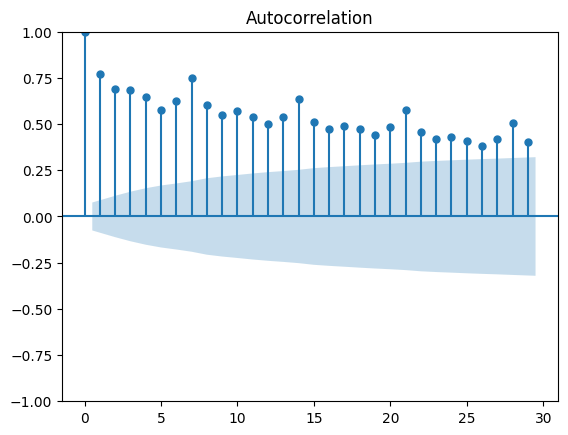

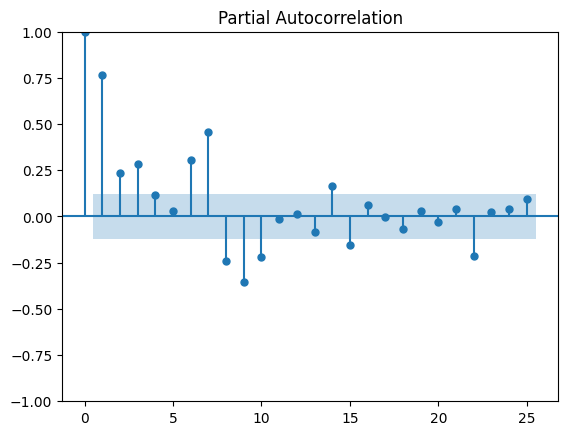

In [ ]:
acf_original = plot_acf(train_us)

pacf_original = plot_pacf(test_us)

In [ ]:
# Check for stationarity of time series
from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(train_us)
print(f'p-value: {adf_test[1]}')

p-value: 0.9823068690232412


<Axes: xlabel='date'>

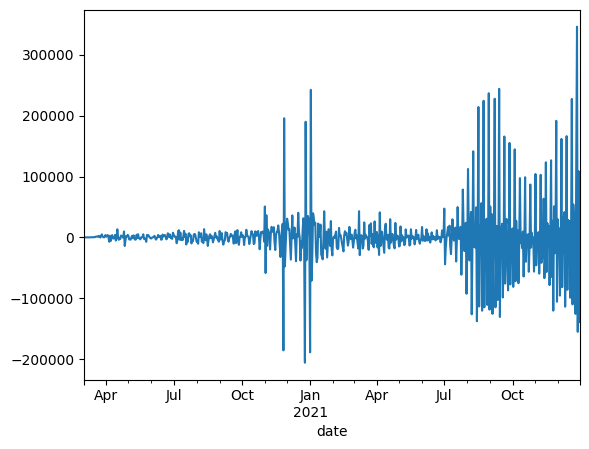

In [ ]:
# differencing
df_train_diff = train_us.diff().dropna()
df_train_diff.plot()

In [ ]:
# check for stationarity d=1
from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(df_train_diff)
print(f'p-value: {adf_test[1]}')
# Although not entirely optimal, but we'll just go forward with it.

p-value: 0.5274252225102461


In [ ]:
from statsmodels.tsa.arima.model import ARIMA
model1 = ARIMA(train_us, order=(7,1,7)).fit()
print(model1.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:          new_confirmed   No. Observations:                  671
Model:                 ARIMA(7, 1, 7)   Log Likelihood               -7839.985
Date:                Sat, 09 Dec 2023   AIC                          15709.970
Time:                        02:51:40   BIC                          15777.579
Sample:                    03-01-2020   HQIC                         15736.158
                         - 12-31-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0718      0.046      1.552      0.121      -0.019       0.163
ar.L2         -0.0785      0.053     -1.479      0.139      -0.183       0.026
ar.L3          0.0413      0.058      0.715      0.4

In [ ]:
def visual_performance(model):
  # fitted value visual
  train_pred=model.predict()
  pd.concat([train_us, train_pred], axis=1).plot(figsize=(20,8))
  plt.legend(['train', 'train_pred'])

  # test data visual
  test_pred=model.predict(start=len(train_us), end=len(train_us)+len(test_us)-1)
  pd.concat([test_us, test_pred], axis=1).plot()
  plt.legend(['test_gt', 'test_pred'])

  # model performance
  train_score = model_performance(train_us, train_pred)
  test_score = model_performance(test_us, test_pred)
  return f"train: {train_score}, test: {test_score}"

'train: RMSE: 29020.14252445639, MAPE: 457.45497600232676, test: RMSE: 725791.8266104878, MAPE: 2250.079676950843'

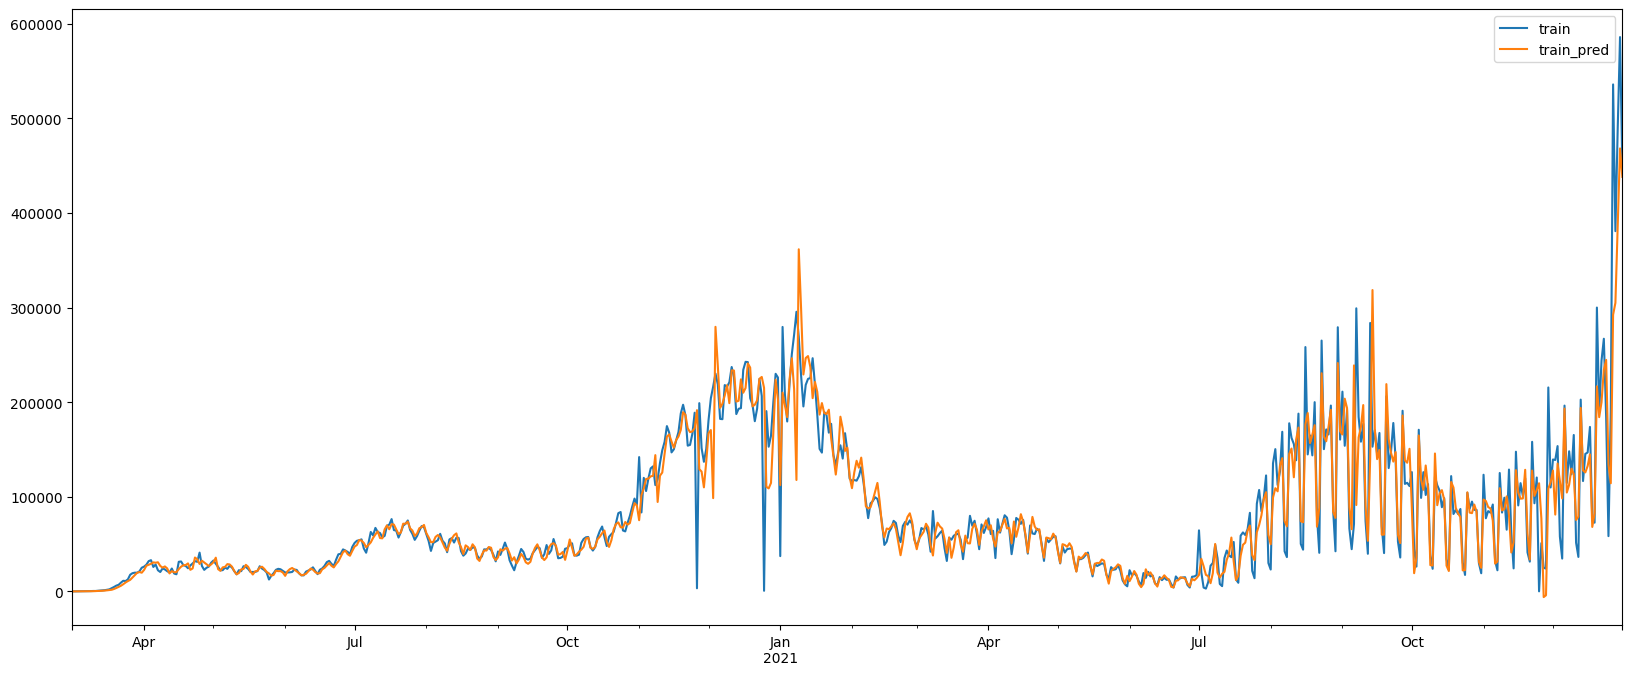

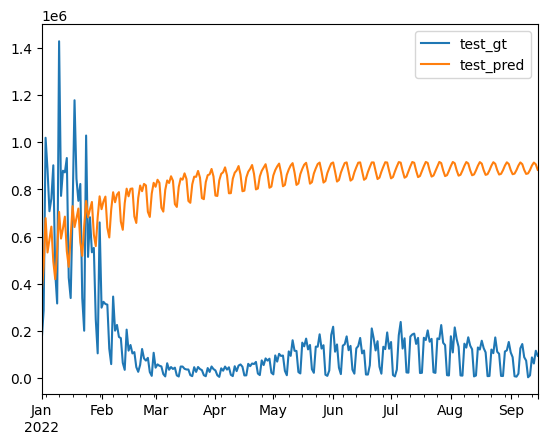

In [ ]:
visual_performance(model1)

In [ ]:
import itertools
param_grid_option = {
    'p': [1,2,3,4,5,6,7],
    'd': [1],
    'q': [1,2,3,4,5,6,7]}

all_params_combination = list(itertools.product(*param_grid_option.values()))
score = 100000
combination = None

for parameters in all_params_combination:
    arima_model = ARIMA(train_us,order=(parameters)).fit()
    aic = arima_model.aic
    if aic < score:
      score = aic
      combination = parameters
    else:
      continue

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dat

In [ ]:
combination

(6, 1, 7)

In [ ]:
model2 = ARIMA(train_us, order=(6,1,7)).fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


'train: RMSE: 28633.743025679392, MAPE: 445.55114493924685, test: RMSE: 382118.4710336718, MAPE: 1159.0689763227874'

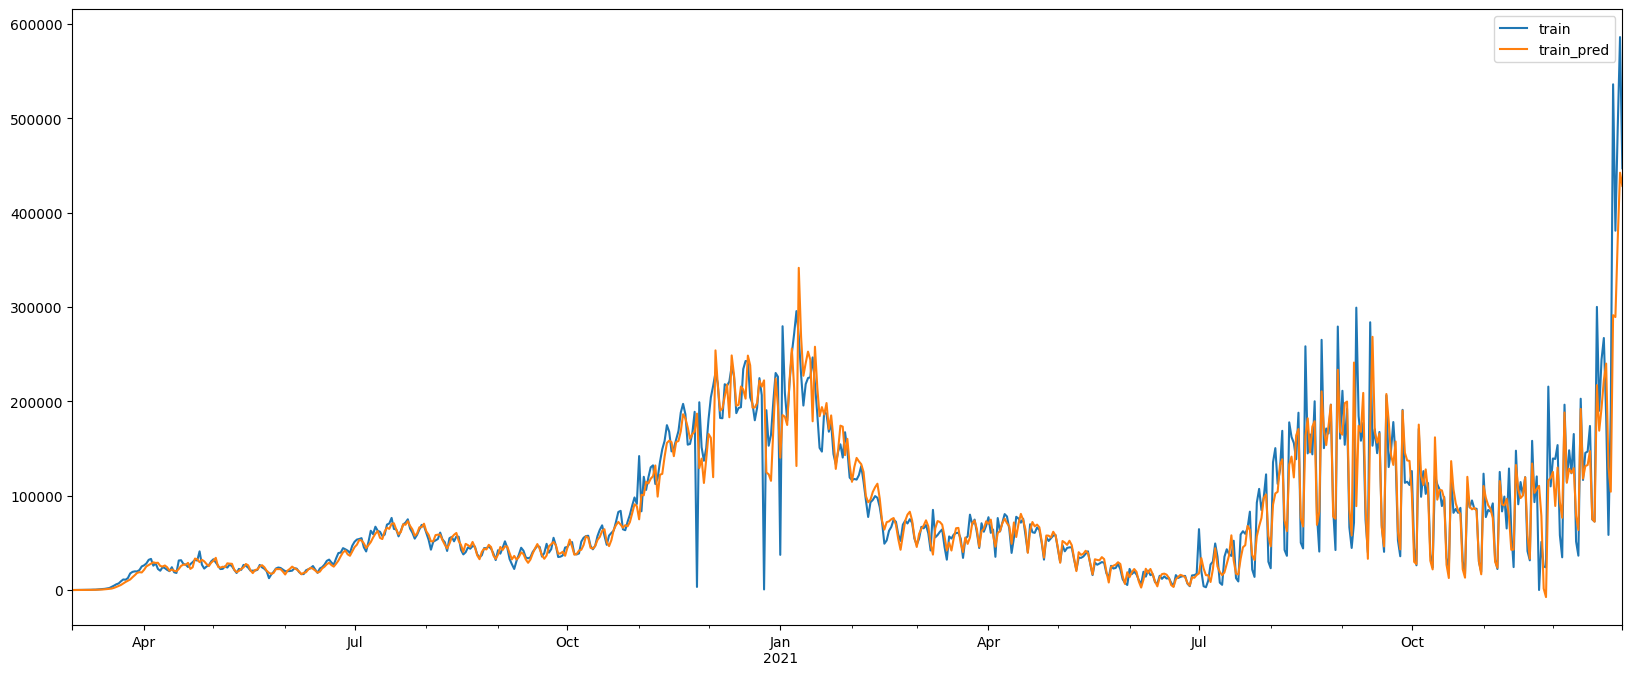

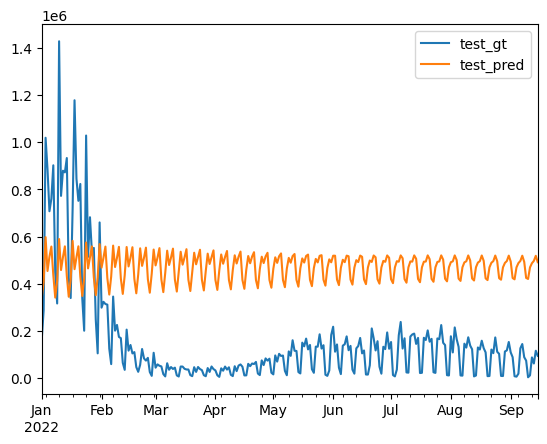

In [ ]:
visual_performance(model2)

In [ ]:
# Ideally, one model should be trained for each country. Due to the time constraint,
# here I apply the US model to the rest 10 countries
train_pred = train_country_agg.copy()
train_pred.new_confirmed = None
train_pred.columns = ['country_code','prediected_new_confirmed']
train_pred.reset_index(inplace = True)
test_pred = test_country_agg.copy()
test_pred.new_confirmed = None
test_pred.columns = ['country_code','prediected_new_confirmed']
test_pred.reset_index(inplace = True)

loc_list = list(train_country_agg.country_code.unique())
for loc in loc_list:
  train_interest = train_country_agg.loc[train_country_agg.country_code == loc, 'new_confirmed']
  test_interest = test_country_agg.loc[test_country_agg.country_code == loc, 'new_confirmed']
  model = ARIMA(train_interest, order=(6,1,7)).fit()
  # Predicct train data
  pred_for_train = model.fittedvalues
  for date in pred_for_train.index:
    train_pred.loc[(train_pred.country_code == loc) & (train_pred.date == date), 'prediected_new_confirmed'] = pred_for_train[date]
  # predict test dataset
  pred_for_test = model.predict(start=len(train_interest), end=len(train_interest)+len(test_interest)-1, dynamic=True)
  pred_for_test.index = test_interest.index
  for date in pred_for_test.index:
    test_pred.loc[(test_pred.country_code == loc) & (test_pred.date == date), 'prediected_new_confirmed'] = pred_for_test[date]

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/u

In [ ]:
# training data
model_performance(train_country_agg.new_confirmed, train_pred.prediected_new_confirmed)

<ipython-input-2-41e2a7920411>:3: RuntimeWarning: invalid value encountered in double_scalars
  return np.mean(np.abs((y_true-y_pred)/y_true)) * 100
<ipython-input-2-41e2a7920411>:3: RuntimeWarning: divide by zero encountered in double_scalars
  return np.mean(np.abs((y_true-y_pred)/y_true)) * 100


'RMSE: 9134.100869326207, MAPE: nan'

In [ ]:
# testing data
model_performance(test_country_agg.new_confirmed, test_pred.prediected_new_confirmed)

<ipython-input-2-41e2a7920411>:3: RuntimeWarning: divide by zero encountered in double_scalars
  return np.mean(np.abs((y_true-y_pred)/y_true)) * 100


'RMSE: 123881.36344354194, MAPE: inf'

In [ ]:
test_pred

,date,country_code,prediected_new_confirmed
0,2022-01-01,AU,2088.670367
1,2022-01-02,AU,2321.571717
2,2022-01-03,AU,2703.640973
3,2022-01-04,AU,2566.700155
4,2022-01-05,AU,3244.335682
...,...,...,...
2565,2022-09-11,US,469195.487703
2566,2022-09-12,US,486786.744759
2567,2022-09-13,US,496730.003147
2568,2022-09-14,US,518281.548185
